In [1]:
from src import Data, myModel
import matplotlib.pyplot as plt

C:\Users\yuch\Downloads\anaconda3\envs\nz_convnet\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### load X-Y samples from block1, and split into train and test sets

In [3]:
data = Data('./data/block1/', start=500, num=500)
X_trn, X_tst, Y_trn, Y_tst = data.trn_tst_split(test_rate=0.1, random_seed=42)

#### visualize images and labels

Text(0.5,1,'lithological mappinp')

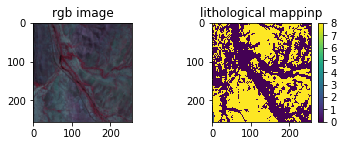

In [62]:
idx = 1
rock_class = 1

img = X_trn[idx,:,:,:]
lbl = Y_trn[idx,:,:,:]

img_rgb = img[:, :, ::-1][:, :, :3]
plt.subplot(221)
plt.imshow(img_rgb)
plt.title('rgb image')
plt.subplot(222)
plt.imshow(np.argmax(lbl, axis=2))
plt.colorbar()
plt.title('lithological mappinp')

#### start to build and train Conv2D

In [5]:
conv = myModel()

# build Conv2D
conv.build_Conv2D(num_bands=10, n_ch_list=[64,64], use_tfboard=True)

# now the tensorboard event file is saved in ./logs
# the training process, graph and statistics can be
# visualize by tensorboard

# compile with loss and optimizer
conv.compile_model(verbose=False)

# build callback for the details of train process
conv.build_callbackList()

building Conv2D ...
[64, 64]
[64]
compiling model ...


In [101]:
# load data from last checkpoint
conv.load_checkpoint()

Conv2D weights loaded, resuming from epoch 22


In [100]:
# start to training
conv.fit_model(X_trn=X_trn, Y_trn=Y_trn, epochs=24, verbose=1)

Train on 360 samples, validate on 90 samples
Epoch 23/24
360/360 [==============================] - 835s 2s/step - loss: 1.3100 - acc: 0.5289 - val_loss: 1.3667 - val_acc: 0.5094

Epoch 00023: val_acc did not improve
Epoch 24/24
 24/360 [=>............................] - ETA: 12:04 - loss: 1.1824 - acc: 0.5884

KeyboardInterrupt: 

#### predict on test data

In [14]:
# conv.save_weights()
# conv.load_weights('./Conv2D/model-1.hdf5')

In [102]:
Y_preds = conv.predict(X_tst=X_tst)

50/50 [==============================] - 41s 826ms/step


#### visualize predicted Y

In [59]:
import numpy as np

Text(0.5,1,'prediction')

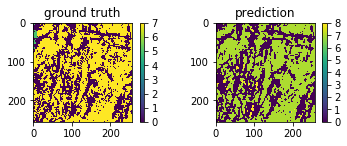

In [104]:
idx = 4
_pred = np.argmax(Y_preds[idx,:,:,:], axis=2)
_tst = np.argmax(Y_tst[idx,:,:,:], axis=2)
plt.subplot(221)
plt.imshow(_tst)
plt.colorbar()
plt.title('ground truth')
plt.subplot(222)
plt.imshow(_pred)
plt.colorbar()
plt.title('prediction')

#### calculate the accuracy

In [105]:
acc_list = []
for i in range(Y_tst.shape[0]):
    tmp_pred = np.argmax(Y_preds[i,:,:,:], axis=2)
    tmp_tst = np.argmax(Y_tst[i,:,:,:], axis=2)
    acc_list.append(np.where(tmp_pred == tmp_tst)[0].shape[0]/(256*256))
print('mean accuracy on test data is {0}, std is {1}'.format(np.mean(acc_list), np.std(acc_list)))
print('max is {0}, min is {1}'.format(max(acc_list), min(acc_list)))

mean accuracy on test data is 0.5960891723632813, std is 0.20863424298893804
max is 0.9349212646484375, min is 0.1726226806640625
